In [1]:
%pip install matplotlib
%pip install pandas
%pip install pint


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pint

In [3]:
ureg = pint.UnitRegistry()

In [4]:
def make_line_better(json):
    if "cpu_atom" in json["event"]:
        return None
    if "instructions" in json["event"]:
        return ("instructions", float(json["counter-value"]), float(json["variance"]))
    if "cycles" in json["event"]:
        return ("cycles", float(json["counter-value"]), float(json["variance"]))
    if "task-clock" in json["event"]:
        t = ureg(json["counter-value"] + " " + json["unit"]).to(ureg("s")).magnitude
        factor = ureg("1 " + json["unit"]).to(ureg("s")).magnitude
        var = float(json["variance"]) * factor * factor
        return ("time", t, var)
    print("Unhandled event: " + json["event"])
    return None

In [81]:
# read the data
def read_qemu_patched(values):
    filenames = map(lambda x: (x, f"qemu_patched_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

def read_qemu(values):
    filenames = map(lambda x: (x, f"qemu_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

def read_qemu_tb_stats(values):
    filenames = map(lambda x: (x, f"qemu_tblog_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = json.load(f)
            temp = temp[:-1]
            (execs, translations) = (filter(lambda x: x["type"] == "exec", temp), filter(lambda x: x["type"] == "trans", temp))
            (execs, translations) = (list(execs), list(translations))
            nbExecs = len(execs)
            nbTranslations = len(translations)
            
            executedInstructions = list(map(lambda x: x["n_insn"], execs))
            translatedInstructions = list(map(lambda x: x["n_insn"], translations))
            vals.append((nbExecs, nbTranslations, executedInstructions, translatedInstructions))
    
    return (values, zip(*vals))

In [82]:
(indices, (nbTbExec, nbTranslations, executedInstructions, translatedInstructions)) = read_qemu_tb_stats(range(0, 10001, 1000))
print(nbTbExec)
print(nbTranslations)
print(executedInstructions)
print(translatedInstructions)

(1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20)
(1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20)
([3], [512, 491], [512, 512, 512, 467], [512, 512, 512, 512, 512, 443], [512, 512, 512, 512, 512, 512, 512, 419], [512, 512, 512, 512, 512, 512, 512, 512, 512, 395], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 371], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 347], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 323], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 299], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 275])
([3], [512, 491], [512, 512, 512, 467], [512, 512, 512, 512, 512, 443], [512, 512, 512, 512, 512, 512, 512, 419], [512, 512, 512, 512, 512, 512, 512, 512, 512, 395], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 371], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 347], [512, 512, 512, 512, 512, 512, 512, 512, 512

In [11]:
(indices, patched_data) = read_qemu_patched(range(0, 10001, 1000))
patched_data = pd.DataFrame(patched_data, index=indices, columns=["instructions", "instr_var", "cycles", "cycles_var", "time", "time_var"])
display(patched_data)

(indices, data) = read_qemu(range(0, 10001, 1000))
data = pd.DataFrame(data, index=indices, columns=["instructions", "instr_var", "cycles", "cycles_var", "time", "time_var"])
data

,instructions,instr_var,cycles,cycles_var,time,time_var
0,4665088.0,0.04,7944357.0,0.0,0.002909,8.000000e-08
1000,4929600.0,0.04,8865832.0,0.0,0.002973,7.000000e-08
2000,5208047.0,0.04,9804277.0,0.0,0.003048,7.000000e-08
3000,5454115.0,0.04,10742969.0,0.0,0.003094,7.000000e-08
4000,5728549.0,0.05,11681793.0,0.0,0.003152,9.000000e-08
5000,5968116.0,0.04,12623151.0,0.0,0.003199,7.000000e-08
6000,6216037.0,0.04,13562067.0,0.0,0.003248,7.000000e-08
7000,6461583.0,0.03,14500977.0,0.0,0.003296,7.000000e-08
8000,6734549.0,0.04,15439907.0,0.0,0.003369,7.000000e-08
9000,6972600.0,0.03,16381100.0,0.0,0.003405,7.000000e-08


,instructions,instr_var,cycles,cycles_var,time,time_var
0,4702137.0,0.04,7938916.0,0.0,0.003046,1.500000e-07
1000,5309823.0,0.12,9367258.0,0.0,0.003312,1.800000e-07
2000,5663672.0,0.12,10655076.0,0.0,0.003403,1.800000e-07
3000,6070582.0,0.12,11943040.0,0.0,0.003538,1.800000e-07
4000,6244134.0,0.09,13231335.0,0.0,0.003505,1.600000e-07
5000,6721679.0,0.11,14522103.0,0.0,0.003671,1.700000e-07
6000,7134247.0,0.12,15810467.0,0.0,0.003791,1.700000e-07
7000,7340847.0,0.10,17098775.0,0.0,0.003800,1.700000e-07
8000,7572491.0,0.08,18387012.0,0.0,0.003803,1.600000e-07
9000,7987051.0,0.09,19677587.0,0.0,0.003936,1.600000e-07


In [15]:
def plot(data, data_patched):
    # Plot "instructions" with variance
    plt.figure(figsize=(10, 7))

    # Plot "instructions" with variance for both instr_var and cycles_var
    plt.errorbar(data_patched.index, data_patched['instructions'], 
             yerr=data_patched['instr_var'], fmt='o', label='QEMU patched', capsize=5)
    plt.errorbar(data_patched.index, data['instructions'],
               yerr=data['instr_var'], fmt='o', label='QEMU plugin', capsize=5)
    plt.ylabel('# Retired instructions')
    plt.title('Instructions comparison')
    plt.legend()
    plt.grid()
    plt.ylim(bottom=0)
    plt.xlabel("Number of NOPs")


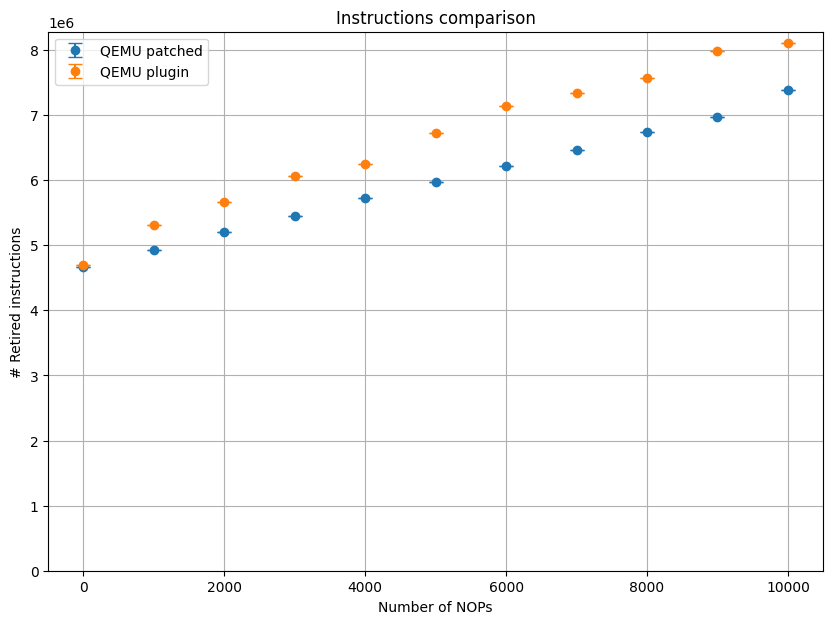

In [16]:
plot(data, patched_data)